
# <center> DPM-Solver

<div align=center>

[KAIST CS492(C): Diffusion and Flow Models (Fall 2025)](https://mhsung.github.io/kaist-cs492c-fall-2025/)

Programming Assignment 2: DPM-Solver

Instructor: [Minhyuk Sung](https://mhsung.github.io) (mhsung [at] kaist.ac.kr)

TA: [Juil Koo](https://63days.github.io/) (63days [at] kaist.ac.kr)

<img src="https://drive.google.com/uc?id=1f4TzEneFq5WVnWFGmUUBiwe-QhDCkyVR"></img>
</div>

## Abstract
DPM-Solver is a novel ordinary differential equation (ODE) solver specifically designed to solve PF-ODEs in just a few steps by exploiting their special structure. The key insight is that the PF-ODE of diffusion models can be decomposed into a linear part and a nonlinear part, a property known as the semi-linear structure. With this decomposition, one can compute the exact solution of the linear part while approximating only the nonlinear part using a Taylor expansion. Increasing the order of the Taylor expansion leads to more accurate solutions. Notably, the authors show that the first-order DPM-Solver is mathematically equivalent to DDIM.


<center>

**Detailed submission guidelines and grading criteria are provided at the end of this Jupyter notebook.**

</center>

## Quick Summary of DPM-Solver

<center>
You can skip this summary and go directly to the implementation part below if you are already familiar with these models.
</center>

In this assignment, we explore a high-order solver of the ODEs for diffusion models. The more accurate the solver is, the faster the sampling can be done with fewer steps. Let's say the forward pass of diffusion models is represented as follows:

$$
\begin{align*}
q(x_t | x_0) = {N}(x_t | \alpha(t) x_0, \sigma^2(t) I).
\end{align*}
$$

The forward pass can be expressed its corresponding SDE form:

$$
dx_t = f(t) x_t dt + g(t) dw_t, \\
\text{where } f(t) = \frac{d \log \alpha_t}{dt} \text{ and } g^2(t) = \frac{d\sigma_t^2}{dt} - 2 \frac{d \log \alpha_t}{dt}\sigma_t^2.
$$

According to [Song et al. [ICLR'21]](https://arxiv.org/abs/2011.13456), we can also compute the ODE form of the _reverse_ process:

$$
\begin{align*}
dx_t = [f(t) x_t + \frac{g^2(t)}{2 \sigma_t} \epsilon_\theta(x_t, t) ] dt,
\end{align*}
$$

which is called Probability Flow ODE (PF-ODE). Note that this ODE equation is a first-order linear non-homogeneous equation, for which exact solution can be computed:

$$
\begin{align*}
x_t = e^{\int_s^t f(\tau) d\tau} x_s + \int_s^t ( e^{\int_\tau^t f(r) dr} \frac{g^2(\tau)}{2 \sigma_\tau} \epsilon_\theta(x_\tau, \tau) ) d\tau,
\end{align*}
$$

where the first term on the right side is a linear term, and the second term, which involves an integral over noise predictions, is a non-linear term.

To simplify the ODE solution equaiton, we introduce a new notation, $\lambda_t := \log (\alpha_t / \sigma_t)$, and use "change-of-variable" for $\lambda$. Then, we have:

$$
\begin{align*}
x_t = \frac{\alpha_t}{\alpha_s} x_s - \alpha_t \int_{\lambda_s}^{\lambda_t} e^{-\lambda} \hat{\epsilon}_\theta (\hat{x}_\lambda, \lambda) d\lambda,
\end{align*}
$$

where $\hat{x}_\lambda := x_{t(\lambda)}$ and $\hat{\epsilon}_\theta (\hat{x}_\lambda, \lambda):= \epsilon_\theta (x_{t(\lambda)}, t(\lambda))$.

Now the simplified solution reveals the integral is represented as the _exponentially weighted integral_ of $\hat{\epsilon}_\theta$, which is closely related to the _exponential integrators_ commonly discussed in the literature of ODE solvers.

We can apply a Taylor expansion into the solution:

$$
\begin{align*}
\hat{\epsilon}_\theta (\hat{x}_\lambda, \lambda) = \sum_{n=0}^{k-1} \frac{(\lambda - \lambda\_{s})^n}{n!} \hat{\epsilon}_\theta^{(n)} (\hat{x}_{\lambda_s}, \lambda_s) + {O}((\lambda - \lambda_s)^k),
\end{align*}
$$

where $\hat{\epsilon}^{(n)}_\theta$ is the $n$-th order derivative of $\hat{\epsilon}_\theta$.

As a result, we can obtain an approximation for $x_s \rightarrow x_t$ with the $k$-order approximation. For instance, as $k=1$, which is called DPM-Solver-1, the solution is:

$$
\begin{align*}
x_t = \frac{\alpha_t}{\alpha_s} x_s - \sigma_t (e^{h}-1) \epsilon_\theta (x_s, s), \text{ where } h = \lambda_t - \lambda_s.
\end{align*}
$$

For $k \leq 2$, Taylor expansion needs additional intermediate points between $t$ and $s$. Below is an algorithm when $k=2$, called DPM-Solver-2.

<img src="https://drive.google.com/uc?id=1uqAbHbVC-UoUoGlnf_hbElay0uXswt84"></img>

## Setup

Before getting started, go to `Runtime` → `Change runtime type` on the top menu bar, and choose **T4 GPU** under Hardware Accelerator.

You should then see `True` and the GPU status with the commands below:

In [6]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

True
Tue Dec  9 17:23:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:07:00.0  On |                  N/A |
|  0%   42C    P8             18W /  170W |     554MiB /  12288MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

## Import Dependencies

In [7]:
import io
import math
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
from sklearn import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random

## Dataset and Utils

In [8]:
SEED = 63 # for reproducibility (Oct 14th)
def seed_everything(seed: int, cuda: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda and torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (some operations may still be nondeterministic)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor


def chamfer_distance(S1, S2) -> float:
    r"""
    Computes the Chamfer distance between two point clouds defined as:
    d_CD(S1, S2) = \sigma_{x \in S1} min_{y in S2} ||x - y||^2 + \sigma_{y \in S2} min_{x in S1} ||x - y||^2
    """
    dist = cdist(S1, S2)
    dist1 = dist.min(axis=1) ** 2
    dist2 = dist.min(axis=0) ** 2
    return dist1.sum() + dist2.sum()


def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample


def load_twodim(num_samples: int, dataset: str, dimension: int = 2):

    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = datasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )


def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


## Visualize target and prior distributions

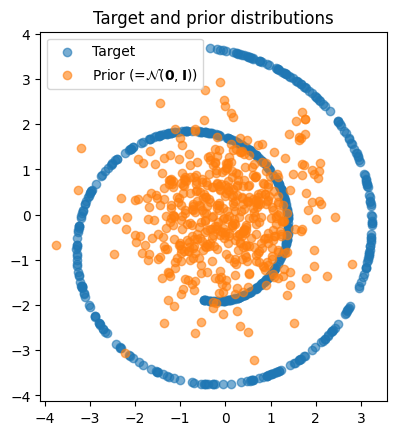

In [9]:
seed_everything(SEED) # for reproducibility (Oct 14th)

target_ds = TwoDimDataClass(dataset_type='swiss_roll',
                            N=1000000,
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

## Copy the Previous Implementation

Copy the neural network implementation from Assignment 1.

In [10]:
class TimeEmbedding(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)

        return alpha * x


class SimpleNet(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: List[int], num_timesteps: int
    ):
        super().__init__()
        """
        (TODO) Build a noise estimating network.

        Args:
            dim_in: dimension of input
            dim_out: dimension of output
            dim_hids: dimensions of hidden features
            num_timesteps: number of timesteps
        """

        ######## TODO ########
        # DO NOT change the code outside this part.
        # <--- solution --->
        self.tlins = nn.ModuleList()
        dims = [dim_in] + dim_hids + [dim_out]
        for i in range(len(dims) - 1):
            tlin = TimeLinear(dims[i], dims[i + 1], num_timesteps)
            self.tlins.append(tlin)
        # <----------------->
        ######################

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        (TODO) Implement the forward pass. This should output
        the noise prediction of the noisy input x at timestep t.

        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # <--- solution --->
        for i in range(len(self.tlins)):
            x = self.tlins[i](x, t)
            if i != len(self.tlins) - 1:
                x = F.relu(x)

        # <---------------->
        ######################
        return x


## Complete a DPM-Solver scheduler.

DPM-Solver uses slightly different notations for the time-dependent scheduling parameters, $\alpha(t)$ and $\sigma(t)$, from DDPM. We provide the `_convert_notations_ddpm_to_dpm()` function that converts DDPM's scheduling parameters into those of DPM-Solver.

Given these changed notations, implement:
- `first_order_step()` and `second_order_step()` in the `DPMSolverScheduler` class
- `q_sample()` and `compute_loss()` in the `DPM` class




In [ ]:
class DPMSolverScheduler(nn.Module):
    """
    Variance scheduler of DDPM.
    """

    def __init__(
        self,
        num_train_timesteps: int,
        beta_1: float = 1e-4,
        beta_T: float = 0.02,
        mode: str = "linear",
    ):
        super().__init__()
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = torch.from_numpy(
            np.arange(0, self.num_train_timesteps)[::-1].copy().astype(np.int64)
        )

        if mode == "linear":
            betas = torch.linspace(beta_1, beta_T, steps=num_train_timesteps)
        elif mode == "quad":
            betas = (
                torch.linspace(beta_1**0.5, beta_T**0.5, num_train_timesteps) ** 2
            )
        else:
            raise NotImplementedError(f"{mode} is not implemented.")

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Compute alphas and alphas_cumprod.

        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim = 0)

        ######################

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

        self._convert_notations_ddpm_to_dpm()
        self.net_forward_fn = None

    def _convert_notations_ddpm_to_dpm(self):
        """
        Based on the forward passes of DDPM and DPM-Solver, convert the notations of DDPM to those of DPM-Solver.
        Refer to Eq. 4 in the DDPM paper and Eq. 2.1 in the DPM-Solver paper.
        """
        dpm_alphas = torch.sqrt(self.alphas_cumprod)
        dpm_sigmas = torch.sqrt(1 - self.alphas_cumprod)
        dpm_lambdas = torch.log(dpm_alphas) - torch.log(dpm_sigmas)

        self.register_buffer("dpm_alphas", dpm_alphas)
        self.register_buffer("dpm_sigmas", dpm_sigmas)
        self.register_buffer("dpm_lambdas", dpm_lambdas)

        dpm_alpha_last = torch.tensor(1.)
        dpm_sigma_last = torch.tensor(0.)
        dpm_lambda_last = torch.tensor(0.)

        self.register_buffer("dpm_alpha_last", dpm_alpha_last)
        self.register_buffer("dpm_sigma_last", dpm_sigma_last)
        self.register_buffer("dpm_lambda_last", dpm_lambda_last)

    def set_timesteps(
        self, num_inference_timesteps: int, device: Union[str, torch.device] = None
    ):
        if num_inference_timesteps > self.num_train_timesteps:
            raise ValueError(
                f"num_inference_timesteps ({num_inference_timesteps}) cannot exceed self.num_train_timesteps ({self.num_train_timesteps})"
            )

        self.num_inference_timesteps = num_inference_timesteps

        #Uniform t
        timesteps = (
            np.linspace(0, self.num_train_timesteps - 1, num_inference_timesteps + 1)
            .round()[::-1][:-1]
            .copy()
            .astype(np.int64)
        )
        self.timesteps = torch.from_numpy(timesteps)

        #Uniform lambda
        # step_size = self.num_train_timesteps // num_inference_timesteps
        # lambdas = torch.flip(self.dpm_lambdas, dims=(0,))[::step_size][:num_inference_timesteps]
        # timesteps = self.inverse_lambda(lambdas)
        # self.timesteps = timesteps

    def inverse_lambda(self, lamb):
        log_alpha_array = torch.log(self.dpm_alphas).reshape(1, -1)
        t_array = torch.linspace(0, 1, self.num_train_timesteps+1)[1:].reshape(1,-1).to(log_alpha_array)
        log_alpha = -0.5 * torch.logaddexp(torch.zeros((1,)).to(lamb.device), -2. * lamb)                # alpha^2 + sigma^2 = 1와 람다-알파-시그마 관계식 정리하여 alpha를 lambda로 표현
        t = interpolate_fn(log_alpha.reshape((-1, 1)), torch.flip(log_alpha_array, [1]),                 # 그 alpha에 대응되는 timestep이 정확히 없으므로 interpolate하여 가장 가까운곳 찾음
                           torch.flip(t_array, [1]))

        """
        Convert continuous t in [1 / N, 1] to discrete [0, 1000 * (N-1)/N]
        """
        t = ((t - 1 / self.num_train_timesteps) * 1000).long()
        return t.squeeze()


    def first_order_step(self, x_s, s, t, eps_theta):
        assert torch.all(s > t), f"timestep s should be larger than timestep t"
        ######## TODO ########
        # DO NOT change the code outside this part.

        alpha_s = extract(self.dpm_alphas, s, x_s)
        alpha_t = extract(self.dpm_alphas, t, x_s)
        sigma_s = extract(self.dpm_sigmas, s, x_s)
        sigma_t = extract(self.dpm_sigmas, t, x_s)

        lambda_s = extract(self.dpm_lambdas, s, x_s)
        lambda_t = extract(self.dpm_lambdas, t, x_s)
        h = lambda_t - lambda_s

        # x_t = (alpha_t / alpha_s) * x_s - sigma_t * eps_theta 근사해 버전

        x_t = (alpha_t / alpha_s) * x_s \
          - sigma_t * (torch.exp(h) - 1.0) * eps_theta

        #######################
        return x_t

    def second_order_step(self, x_ti1, t_i1, t_i, eps_theta):
        """
        x_ti1: x_{t_{i-1}}
        t_i1: t_{i-1}
        t_i: t_i
        eps_theta: eps_\theta(x_{t_{i-1}}, t_{i-1})
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        lambda_i1 = extract(self.dpm_lambdas, t_i1, x_ti1)
        lambda_i = extract(self.dpm_lambdas, t_i, x_ti1)
        h = lambda_i - lambda_i1  
        s_i = self.inverse_lambda((lambda_i1 + lambda_i)/2)

        alpha_s   = extract(self.dpm_alphas, t_i1, x_ti1)    # α_{t_{i-1}}
        alpha_mid = extract(self.dpm_alphas, s_i,  x_ti1)    # α_{s_i}
        alpha_t   = extract(self.dpm_alphas, t_i,  x_ti1)    # α_{t_i}

        sigma_mid = extract(self.dpm_sigmas, s_i,  x_ti1)    # σ_{s_i}
        sigma_t   = extract(self.dpm_sigmas, t_i,  x_ti1)    # σ_{t_i}

        # An example of computing noise prediction inside the function.
        u_i = (alpha_mid / alpha_s) * x_ti1 \
          - sigma_mid * (torch.exp(0.5 * h) - 1.0) * eps_theta
        eps_mid = self.net_forward_fn(u_i, s_i.to(x_ti1.device))

        x_ti = (alpha_t / alpha_s) * x_ti1 \
           - sigma_t * (torch.exp(h) - 1.0) * eps_mid
        #######################
        return x_ti


    def step(
        self,
        x_t: torch.Tensor,
        t: Union[torch.IntTensor, int],
        eps_theta: torch.Tensor,
        order=1,
    ):
        """
        One step denoising function of DPM-Solver: x_t -> x_{t-1}.

        Input:
            x_t (`torch.Tensor [B,C,H,W]`): samples at arbitrary timestep t.
            t (`int` or `torch.Tensor [B]`): current timestep in a reverse process.
            eps_theta (`torch.Tensor [B,C,H,W]`): predicted noise from a learned model.
        Ouptut:
            sample_prev (`torch.Tensor [B,C,H,W]`): one step denoised sample. (= x_{t-1})

        """
        t_prev = (t - self.num_train_timesteps // self.num_inference_timesteps).clamp(0)    # t에서 t_prev를 예측
        if order == 1:
            sample_prev = self.first_order_step(x_t, t, t_prev, eps_theta)
        elif order == 2:
            sample_prev = self.second_order_step(x_t, t, t_prev, eps_theta)

        return sample_prev

"""
Source: https://github.com/LuChengTHU/dpm-solver/blob/main/dpm_solver_pytorch.py
"""
def interpolate_fn(x, xp, yp):          # (새로운 알파, 알파 전체 배열, 알파 배열에 대응되는 타임스텝 배열) -> 새로운 알파가 알파 전체배열중 어디에 위치한지 구한후, 타임스텝 배열에서 찾기
    """
    A piecewise linear function y = f(x), using xp and yp as keypoints.
    We implement f(x) in a differentiable way (i.e. applicable for autograd).
    The function f(x) is well-defined for all x-axis. (For x beyond the bounds of xp, we use the outmost points of xp to define the linear function.)

    Args:
        x: PyTorch tensor with shape [N, C], where N is the batch size, C is the number of channels (we use C = 1 for DPM-Solver).
        xp: PyTorch tensor with shape [C, K], where K is the number of keypoints.
        yp: PyTorch tensor with shape [C, K].
    Returns:
        The function values f(x), with shape [N, C].
    """
    N, K = x.shape[0], xp.shape[1]
    all_x = torch.cat([x.unsqueeze(2), xp.unsqueeze(0).repeat((N, 1, 1))], dim=2)
    sorted_all_x, x_indices = torch.sort(all_x, dim=2)
    x_idx = torch.argmin(x_indices, dim=2)
    cand_start_idx = x_idx - 1
    start_idx = torch.where(
        torch.eq(x_idx, 0),
        torch.tensor(1, device=x.device),
        torch.where(
            torch.eq(x_idx, K), torch.tensor(K - 2, device=x.device), cand_start_idx,
        ),
    )
    end_idx = torch.where(torch.eq(start_idx, cand_start_idx), start_idx + 2, start_idx + 1)
    start_x = torch.gather(sorted_all_x, dim=2, index=start_idx.unsqueeze(2)).squeeze(2)
    end_x = torch.gather(sorted_all_x, dim=2, index=end_idx.unsqueeze(2)).squeeze(2)
    start_idx2 = torch.where(
        torch.eq(x_idx, 0),
        torch.tensor(0, device=x.device),
        torch.where(
            torch.eq(x_idx, K), torch.tensor(K - 2, device=x.device), cand_start_idx,
        ),
    )
    y_positions_expanded = yp.unsqueeze(0).expand(N, -1, -1)
    start_y = torch.gather(y_positions_expanded, dim=2, index=start_idx2.unsqueeze(2)).squeeze(2)
    end_y = torch.gather(y_positions_expanded, dim=2, index=(start_idx2 + 1).unsqueeze(2)).squeeze(2)
    cand = start_y + (x - start_x) * (end_y - start_y) / (end_x - start_x)
    return cand

def extract(input, t: torch.Tensor, x: torch.Tensor):
    if t.ndim == 0:
        t = t.unsqueeze(0)
    shape = x.shape
    t = t.long().to(input.device)
    out = torch.gather(input, 0, t)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

class DPM(nn.Module):

    def __init__(self, network: nn.Module, var_scheduler: DPMSolverScheduler):
        super().__init__()
        self.network = network
        self.var_scheduler = var_scheduler
        # make the network forward function accessible inside the scheduler for high-order sampling.
        self.var_scheduler.net_forward_fn = self.network.forward

    @property
    def device(self):
        return next(self.network.parameters()).device

    def q_sample(self, x0, t, noise=None):
        """
        sample x_t from q(x_t | x_0) of DPM-Solver.

        Input:
            x0 (`torch.Tensor`): clean data to be mapped to timestep t in the forward process of DPM-Solver.
            t (`torch.Tensor`): timestep
            noise (`torch.Tensor`, optional): random Gaussian noise. if None, randomly sample Gaussian noise in the function.
        Output:
            xt (`torch.Tensor`): noisy samples
        """
        if noise is None:
            noise = torch.randn_like(x0)

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Implement the DPM-Solver's forward step, following Equation 2.1 of the DPM-Solver paper.
        dpm_alpha_t = extract(self.var_scheduler.dpm_alphas, t, x0)
        dpm_sigma_t = extract(self.var_scheduler.dpm_sigmas, t, x0)
        xt = dpm_alpha_t * x0 + dpm_sigma_t * noise

        #######################

        return xt

    @torch.no_grad()
    def sample(
        self,
        shape,
        num_inference_timesteps=50,
        order=1
        ):
        x_T = torch.randn(shape).to(self.device)

        traj = [x_T]
        self.var_scheduler.set_timesteps(num_inference_timesteps//order)     # order의 수 : solver 수 -> 높을수록 스텝당 정확히 계산 -> 스텝당 시간의 수 증가, 전체 스텝수는 감소
        timesteps = self.var_scheduler.timesteps
        for t in tqdm(timesteps):
          x_t = traj[-1]
          noise_pred = self.network(x_t, t.to(self.device))
          x_t_prev = self.var_scheduler.step(x_t, t, noise_pred, order)
          traj[-1] = traj[-1].cpu()
          traj.append(x_t_prev.detach())

        x0_pred = traj[-1]

        return x0_pred

    def compute_loss(self, x0):
        """
        The simplified noise matching loss corresponding Equation 14 in DDPM paper.

        Input:
            x0 (`torch.Tensor`): clean data
        Output:
            loss: the computed loss to be backpropagated.
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute noise matching loss.
        batch_size = x0.shape[0]
        t = (
            torch.randint(0, self.var_scheduler.num_train_timesteps, size=(batch_size,))
            .to(x0.device)
            .long()
        )
        
        noise = torch.randn_like(x0)

        x_t = self.q_sample(x0, t, noise)

        eps_pred = self.network(x_t, t)

        loss = ((noise - eps_pred) ** 2).mean()

        ######################
        return loss

## Build a DPM

In [13]:
# hyperparameters #
# Don't change it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128, 128, 128], # Updated (Oct 14th). Previosuly, [128, 128, 128]
    "lr": 5e-4, # Updated (Oct 14th). Previously, 1e-3
    "batch_size": 128,
    "num_train_iters": 10_000, # Updated (Oct 14th), Previosuly, 5000
    "device": device,
    "num_inference_steps": 50,
}
###################

def build_dpm(config):
    network = SimpleNet(dim_in=2,
                        dim_out=2,
                        dim_hids=config["dim_hids"],
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = DPMSolverScheduler(config["num_diffusion_steps"])
    var_scheduler.set_timesteps(config["num_inference_steps"])

    dpm = DPM(network, var_scheduler).to(config["device"])
    return dpm

dpm = build_dpm(config)

## Visualize $q(\mathbf{x}_t)$

Once you finish the implementation so far, you should be able to see that the swiss-roll distribution on the leftmost gradually transforms into a Gaussian distribution as $t$ increases.

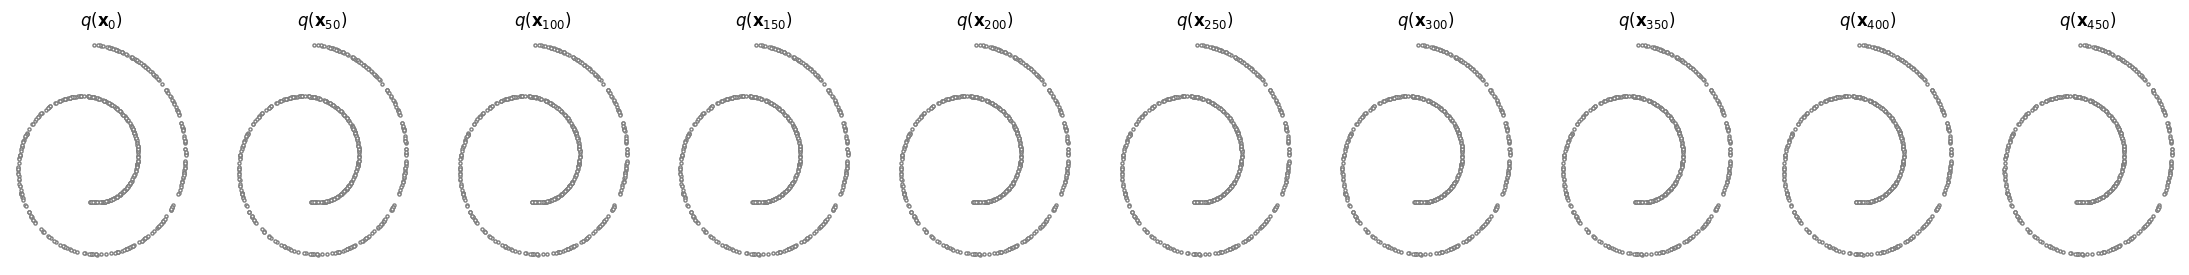

In [15]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i, t in enumerate(range(0, 500, 50)):
    x_t = dpm.q_sample(target_ds[:num_vis_particles].to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title(r'$q(\mathbf{x}_{'+str(t)+'})$')

## Training

In [ ]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# for reproducibility (Oct 14th)
seed_everything(SEED)

# Initialize the model.
dpm = build_dpm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(dpm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()

        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = dpm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

        if step % 199 == 0:
            with torch.no_grad():
                x0 = dpm.sample(shape=(num_vis_particles, 2)).cpu()

                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)

except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

## Evaluation

In [ ]:
# for reproducibility (Oct 14th)
seed_everything(SEED)

# first-order DPM-Solver
num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = dpm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=50, order=1)

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"DPM-Solver-1 Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

In [ ]:
# for reproducibility (Oct 14th)
seed_everything(SEED)

# second-order DPM-Solver
num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = dpm.sample(shape=(num_eval_particles, 2), num_inference_timesteps=50, order=2)

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"DPM-Solver-2 Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

## What to Submit

<details>
<summary><b>Submission Item List</b></summary>
</br>

- [ ] Jupyter notebook file

- [ ] Loss curve screenshot
- [ ] Chamfer Distance (screenshot) for DPM-Solver-1
- [ ] Sampling visualization for DPM-Solver-1

- [ ] Chamfer Distance (screenshot) for DPM-Solver-2
- [ ] Sampling visualization for DPM-Solver-2

</details>


Submit a single ZIP file named `{NAME}_{STUDENT_ID}.zip` containing the two followings:

1. Jupyter notebook file containing your code implementation.
2. A single PDF document named `{NAME}_{STUDENT_ID}.pdf` that includes:
    - Your name and student ID
    - All results listed in the submission item list above (screenshots, metrics, visualizations, etc.)


## Grading

**You will receive a zero score if:**
- **you do not submit,**
- **your code is not reproducible, or**
- **you modify any code outside of the section enclosed with `TODO` or use different hyperparameters that are supposed to be fixed as given.**

**Plagiarism in any form will also result in a zero score and will be reported to the university.**

**Your score will incur a 10% deduction for each missing item.**

Otherwise, you will receive up to 20 points from this assignment that count toward your final grade.

- Task 1 (DPM-Solver-1)
  - 10 points: Achieve CD lower than **40**.
  - 5 points: Achieve CD between **40** and **80**.
  - 0 point: otherwise.
- Task 2 (DPM-Solver-2)
  - 10 points: Achieve CD lower than **40**.
  - 5 points: Achieve CD between **40** and **80**.
  - 0 point: otherwise.


## Further Readings

If you are interested in this topic, we encourage you to check out the further materials below.

- [DPM-Solver: A Fast ODE Solver for Diffusion Probabilistic Model Sampling in Around 10 Steps](https://arxiv.org/abs/2206.00927)
- [DPM-Solver++: Fast Solver for Guided Sampling of Diffusion Probabilistic Models](https://arxiv.org/abs/2211.01095)
- [Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456)
- [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)
